# 5. Train model

In [ ]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

import plotly.io as pio
pio.renderers.default = "notebook_connected"
from optuna.visualization import plot_optimization_history, plot_param_importances

In [2]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
DATA = os.path.join(ROOT, "data")
EXTERNAL_DATA = os.path.join(DATA, "external") 
INTERIM_DATA = os.path.join(DATA, "interim")
RAW_DATA = os.path.join(DATA, "raw")
FIGURES = os.path.join(ROOT, "reports", "figures")
PROCESSED_DATA = os.path.join(DATA, "processed")

In [3]:
feature_cols_glm = [
    "dow",
    "is_weekend",
    "weekofyear",
    "sin_doy",
    "cos_doy",
    "is_holiday_BE",
    "temperature_2m_mean",
    "precipitation_sum",
    "wind_speed_10m_max",
    "sunshine_h",
    "precip_sum_lag1",
    "precip_sum_roll3",
    "t_mean_lag1",
    "sunshine_roll7",
    "is_rainy",
    "is_hot",
    "is_cold",
    "y_lag1",
    "y_lag7",
    "y_roll7",
    "y_diff1",
    "zero_streak",
    "rate_prev_mean_1k",
    "pop_density_km2",
    "poi_density_km2",
    "spatial_lag_y_roll7",
    "attempt_rate_roll7_prev",
    "price_median_clip_roll7_prev",
    "share_bt_diamond_frame_roll7_prev",
    "share_bt_step_through_roll7_prev",
    "share_bt_generic_roll7_prev",
    "share_bt_kids_roll7_prev",
    "share_bt_mtb_roll7_prev",
    "share_bt_other_roll7_prev"
]

offset_col = "offset_log_pop"
target_col = "y_count"

feature_columns = feature_cols_glm + ["offset_log_pop"]

## Load data

In [4]:
df_train = pd.read_parquet(
    os.path.join(INTERIM_DATA, 'df_train.geoparquet.gzip')
)
df_val = pd.read_parquet(
    os.path.join(INTERIM_DATA, 'df_val.geoparquet.gzip'),
)
df_test = pd.read_parquet(
    os.path.join(INTERIM_DATA, 'df_test.geoparquet.gzip')
)

## Prepare data

In [ ]:
X_tr = df_train[feature_cols_glm].copy()
X_va = df_val[feature_cols_glm].copy()
X_va = X_va.reindex(columns=X_tr.columns)

# Remove inf and make it numeric
X_tr = X_tr.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
X_va = X_va.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

# Fell zero-like features with 0
zero_like_tokens = ["y_lag","y_roll","y_diff","zero_streak",
                    "spatial_lag","_roll7_prev","_roll28_prev","rate_prev_mean"]
zero_like_cols = [c for c in X_tr.columns if any(tok in c for tok in zero_like_tokens)]
X_tr[zero_like_cols] = X_tr[zero_like_cols].fillna(0.0)
X_va[zero_like_cols] = X_va[zero_like_cols].fillna(0.0)

# Fill with median value from train
imp = X_tr.median(numeric_only=True)
X_tr = X_tr.fillna(imp)
X_va = X_va.fillna(imp.reindex(X_va.columns))

# Target and population columns
y_tr = df_train[target_col].astype(float).values
y_va = df_val[target_col].astype(float).values
pop_tr = df_train["population_total"].astype(float).clip(lower=1.0).values
pop_va = df_val["population_total"].astype(float).clip(lower=1.0).values

# target train metric - rate for 1000 of inhabitats
rate_tr = y_tr / pop_tr * 1000.0
rate_va = y_va / pop_va * 1000.0

## Poisson-GLM model

In [6]:
import numpy as np
import statsmodels.api as sm

off_tr = df_train[offset_col].astype(float).values
off_va = df_val[offset_col].astype(float).values

Xm_tr = sm.add_constant(X_tr, has_constant="add")
Xm_va = sm.add_constant(X_va, has_constant="add")

res_poi = sm.GLM(y_tr, Xm_tr, family=sm.families.Poisson(), offset=off_tr).fit()
pred_va = res_poi.predict(Xm_va, offset=off_va)
mae  = mean_absolute_error(y_va, pred_va)
rmse = mean_squared_error(y_va, pred_va) ** 0.5
print(f"MAE={mae:.3f}  RMSE={rmse:.3f}")

MAE=0.297  RMSE=0.442


MAE=0.306  RMSE=0.442

## NegativeBinomial-GLM model

In [7]:
best_alpha, best_mae, best_res = None, np.inf, None
for alpha in [0.03, 0.1, 0.3, 1.0, 3.0]:
    fam = sm.families.NegativeBinomial(alpha=alpha)
    res = sm.GLM(y_tr, Xm_tr, family=fam, offset=off_tr).fit()
    pred = res.predict(Xm_va, offset=off_va)
    mae  = mean_absolute_error(y_va, pred)
    if mae < best_mae:
        best_alpha, best_mae, best_res = alpha, mae, res

pred_va_cnt_nb = best_res.predict(Xm_va, offset=off_va)

print(f"NegBin-GLM (alpha={best_alpha})  MAE={mean_absolute_error(y_va, pred_va_cnt_nb):.3f}  RMSE={mean_squared_error(y_va, pred_va_cnt_nb) ** 0.5:.3f}")

NegBin-GLM (alpha=0.3)  MAE=0.265  RMSE=0.614


NegBin-GLM (alpha=0.3)  MAE=0.259  RMSE=0.490

## LightGBM

In [8]:
dtrain = lgb.Dataset(X_tr, label=rate_tr, feature_name=list(X_tr.columns))
dvalid = lgb.Dataset(X_va, label=rate_va, reference=dtrain, feature_name=list(X_tr.columns))

params = dict(
    metric="rmse",
    seed=42,
    verbose=-1,
)
evals_result = {}
gbm = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dvalid],
    valid_names=["train","val"],
    num_boost_round=4000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200, verbose=False),
        lgb.log_evaluation(period=200),
        lgb.record_evaluation(evals_result)
    ],
)

# --- оценка в двух масштабах: RATE и COUNT ---
val_rate_pred = gbm.predict(X_va, num_iteration=gbm.best_iteration)
rmse_rate = mean_squared_error(rate_va, val_rate_pred) ** 0.5
mae_rate  = mean_absolute_error(rate_va, val_rate_pred)

pred_va_cnt = np.clip(val_rate_pred, 0, None) * pop_va / 1000.0
rmse_cnt = mean_squared_error(y_va, pred_va_cnt) ** 0.5
mae_cnt  = mean_absolute_error(y_va, pred_va_cnt)

print(f"[RATE]  LGBM MAE={mae_rate:.3f}  RMSE={rmse_rate:.3f}")
print(f"[COUNT] LGBM MAE={mae_cnt:.3f}  RMSE={rmse_cnt:.3f}")

# согласованность: длины и finiteness
assert np.isfinite(val_rate_pred).all()
assert len(val_rate_pred) == len(rate_va) == len(y_va) == len(pop_va)

[200]	train's rmse: 0.0568928	val's rmse: 0.102884
[RATE]  LGBM MAE=0.020  RMSE=0.052
[COUNT] LGBM MAE=0.138  RMSE=0.331


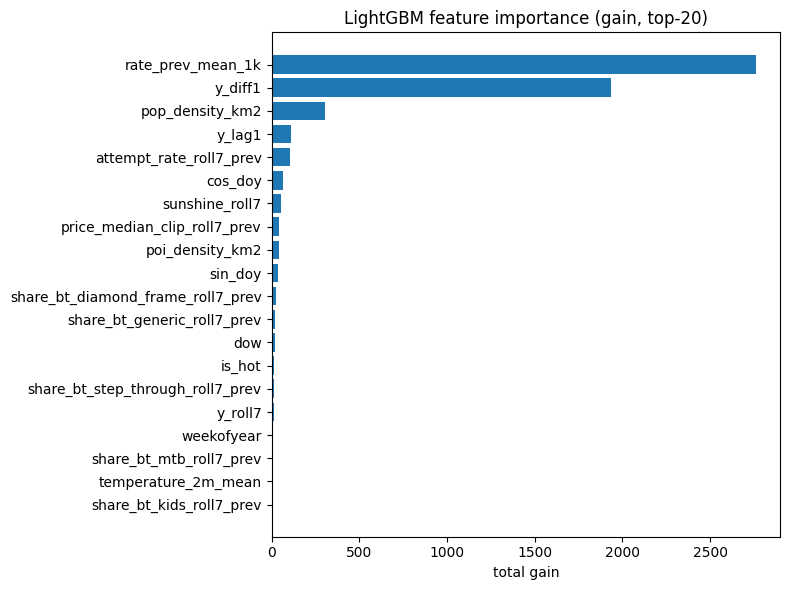

In [9]:
import matplotlib.pyplot as plt

imp = pd.DataFrame({
    "feature": gbm.feature_name(),
    "gain": gbm.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(imp["feature"][::-1], imp["gain"][::-1])
plt.title("LightGBM feature importance (gain, top-20)")
plt.xlabel("total gain")
plt.savefig(os.path.join(FIGURES, "lgbm_feature_importance_default.png"))
plt.tight_layout()

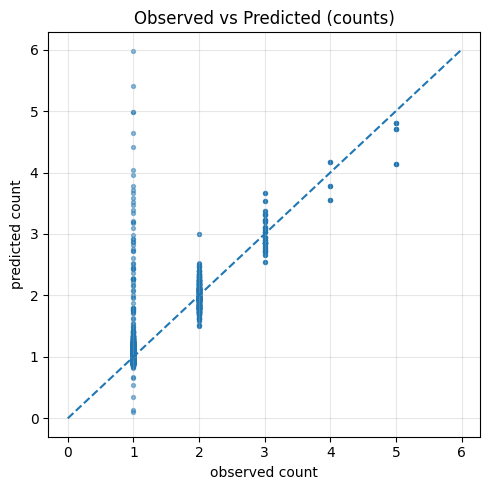

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(y_va, pred_va_cnt, s=8, alpha=0.5)
mn = 0
mx = max(y_va.max(), pred_va_cnt.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.title("Observed vs Predicted (counts)")
plt.xlabel("observed count")
plt.ylabel("predicted count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES, "lgbm_observed_vs_predicted_default.png"))
plt.show()

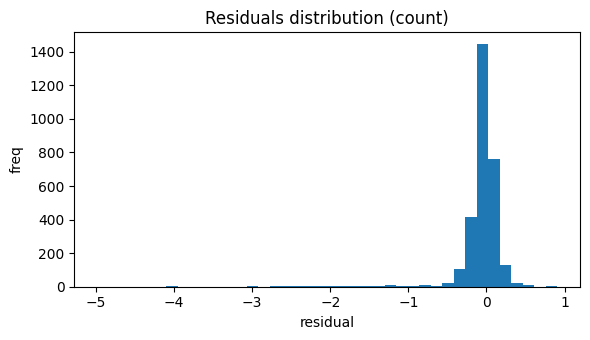

In [11]:
resid = y_va - pred_va_cnt

plt.figure(figsize=(6,3.5))
plt.hist(resid, bins=40)
plt.title("Residuals distribution (count)")
plt.xlabel("residual")
plt.ylabel("freq")
plt.savefig(os.path.join(FIGURES, "lgbm_residuals_distribution_default.png"))
plt.tight_layout()
plt.show()

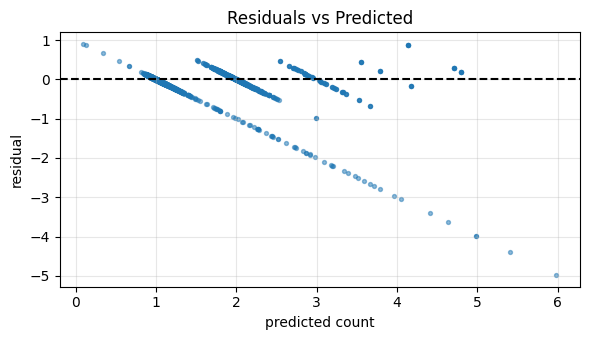

In [12]:
plt.figure(figsize=(6,3.5))
plt.scatter(pred_va_cnt, resid, s=8, alpha=0.5)
plt.axhline(0, color="k", linestyle="--")
plt.title("Residuals vs Predicted")
plt.xlabel("predicted count")
plt.ylabel("residual")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES, "lgbm_residuals_vs_predicted_default.png"))
plt.show()

## Obeservations

Among given models, LightGBM gives the best performance without specific parameters

Let us proceed further with its tuning

## Tune model

* For model tuning, let us use [optuna](https://optuna.readthedocs.io/en/stable/index.html) package

In [13]:
import optuna

def objective(trial):
    dtrain = lgb.Dataset(X_tr, label=rate_tr)
    dvalid = lgb.Dataset(X_va, label=rate_va, reference=dtrain)

    obj = trial.suggest_categorical("objective", ["tweedie", "poisson"])
    params = {
        "objective": obj,
        "metric": "rmse",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "feature_pre_filter": False,
        "verbosity": -1,
        "seed": 42,
        "force_row_wise": True
    }
    if obj == "tweedie":
        params["tweedie_variance_power"] = trial.suggest_float("tweedie_variance_power", 1.1, 1.9)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=["train","val"],
        num_boost_round=10000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=200, verbose=False),
            lgb.log_evaluation(period=100),
        ]
    )

    trial.set_user_attr("best_iteration", int(model.best_iteration))
    val_rate_pred = model.predict(X_va, num_iteration=model.best_iteration)
    rmse_rate = mean_squared_error(rate_va, val_rate_pred) ** 0.5
    return rmse_rate

study = optuna.create_study(direction="minimize", study_name="lgbm_biketheft")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best value (RMSE rate):", study.best_value)
print("Best params:", study.best_params)

[I 2025-11-13 19:17:23,177] A new study created in memory with name: lgbm_biketheft


  0%|          | 0/50 [00:00<?, ?it/s]

[100]	train's rmse: 0.126834	val's rmse: 0.0504693
[200]	train's rmse: 0.106388	val's rmse: 0.037548
[300]	train's rmse: 0.0999405	val's rmse: 0.0359071
[400]	train's rmse: 0.0966143	val's rmse: 0.0349822
[500]	train's rmse: 0.0949823	val's rmse: 0.0338185
[600]	train's rmse: 0.0931181	val's rmse: 0.0322202
[700]	train's rmse: 0.0903612	val's rmse: 0.0306964
[800]	train's rmse: 0.087539	val's rmse: 0.0301167
[900]	train's rmse: 0.0846885	val's rmse: 0.0296801
[1000]	train's rmse: 0.0823389	val's rmse: 0.028742
[1100]	train's rmse: 0.0807194	val's rmse: 0.0281149
[1200]	train's rmse: 0.0760347	val's rmse: 0.0282204
[1300]	train's rmse: 0.0728451	val's rmse: 0.0283286
[I 2025-11-13 19:17:27,944] Trial 0 finished with value: 0.027881289205202896 and parameters: {'objective': 'poisson', 'learning_rate': 0.028207282759320614, 'num_leaves': 203, 'min_data_in_leaf': 156, 'feature_fraction': 0.8760453828642122, 'bagging_fraction': 0.7056136589021803, 'bagging_freq': 6, 'lambda_l1': 1.892939377

In [14]:
best_params = study.best_params.copy()
best_params.update(dict(metric="rmse", verbosity=-1, seed=42, force_row_wise=True))
best_params

{'objective': 'tweedie',
 'learning_rate': 0.027245647648769352,
 'num_leaves': 172,
 'min_data_in_leaf': 148,
 'feature_fraction': 0.855137686289259,
 'bagging_fraction': 0.6483487653883907,
 'bagging_freq': 2,
 'lambda_l1': 0.09340896325308014,
 'lambda_l2': 0.004790726722174753,
 'max_depth': 16,
 'tweedie_variance_power': 1.756099861400011,
 'metric': 'rmse',
 'verbosity': -1,
 'seed': 42,
 'force_row_wise': True}

In [15]:
best_n = int(study.best_trial.user_attrs.get("best_iteration"))
best_n

4251

In [16]:
fig1 = plot_optimization_history(study)
fig1.write_image(os.path.join(FIGURES, "lgbm_plot_optimization_history.png"))
fig1.show()

## Train best model

### Prepare data

In [17]:
# Build train + val dataset for final training
df_trval = pd.concat([df_train, df_val], axis=0, ignore_index=True)

# Feature matrices
X_trval = df_trval[feature_cols_glm].copy()
X_te    = df_test[feature_cols_glm].copy()
X_te    = X_te.reindex(columns=X_trval.columns)  # Identical rows/columns order

# Put all types to numeric
# Clean inf values
for X in (X_trval, X_te):
    X[:] = X.apply(pd.to_numeric, errors="coerce")
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Zero-like features fill with 0
zero_like_tokens = [
    "y_lag","y_roll","y_diff","zero_streak",
    "spatial_lag","_roll7_prev","_roll28_prev","rate_prev_mean"
]
zero_like_cols = [c for c in X_trval.columns if any(tok in c for tok in zero_like_tokens)]
X_trval[zero_like_cols] = X_trval[zero_like_cols].fillna(0.0)
X_te[zero_like_cols]    = X_te[zero_like_cols].fillna(0.0)

# Other NaN values - median from train
imp = X_trval.median(numeric_only=True)
X_trval = X_trval.fillna(imp)
X_te    = X_te.fillna(imp.reindex(X_te.columns))

# Target columns and populations
y_trval = df_trval[target_col].astype(float).values
y_te    = df_test[target_col].astype(float).values
pop_trval = df_trval["population_total"].astype(float).clip(lower=1.0).values
pop_te    = df_test["population_total"].astype(float).clip(lower=1.0).values

# Target column - rate for 1000 inhabitats
rate_trval = (y_trval / pop_trval) * 1000.0

In [18]:
dtrain_final = lgb.Dataset(X_trval, label=rate_trval)
gbm_final = lgb.train(
    best_params,
    dtrain_final,
    num_boost_round=best_n,
    valid_sets=[dtrain_final], valid_names=["train"],
    callbacks=[
            lgb.log_evaluation(period=500)
      ],
)

rate_pred_te = gbm_final.predict(X_te, num_iteration=best_n)
cnt_pred_te  = np.clip(rate_pred_te, 0, None) * pop_te / 1000.0

print("Validation (COUNT)  MAE/RMSE:",
      mean_absolute_error(y_te, cnt_pred_te),
      mean_squared_error(y_te, cnt_pred_te) ** 0.5)

[500]	train's rmse: 0.0923119
[1000]	train's rmse: 0.0845261
[1500]	train's rmse: 0.0793952
[2000]	train's rmse: 0.0747492
[2500]	train's rmse: 0.0698897
[3000]	train's rmse: 0.064957
[3500]	train's rmse: 0.0610875
[4000]	train's rmse: 0.0573665
Validation (COUNT)  MAE/RMSE: 0.0458581721381714 0.07840829135151071


### Visualisation

In [19]:
te_eval = df_test[["date","lor","y_count"]].copy()
te_eval["yhat"]  = cnt_pred_te
te_eval["resid"] = te_eval["y_count"] - te_eval["yhat"]


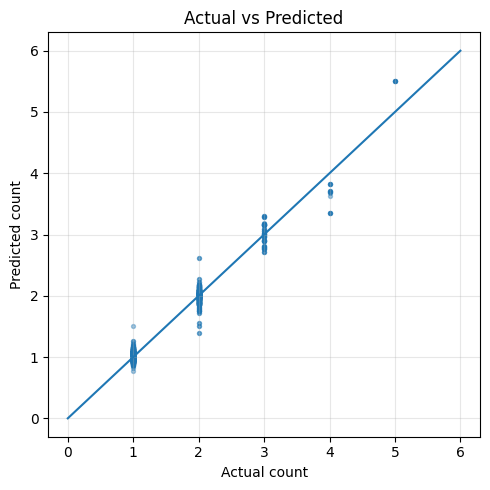

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(te_eval["y_count"], te_eval["yhat"], s=8, alpha=0.4)
lim = [0, float(np.ceil(max(te_eval["y_count"].max(), te_eval["yhat"].max())))]
plt.plot(lim, lim)
plt.xlabel("Actual count")
plt.ylabel("Predicted count")
plt.title("Actual vs Predicted")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "lgbm_actual_vs_predicted_best.png")
)
plt.show()

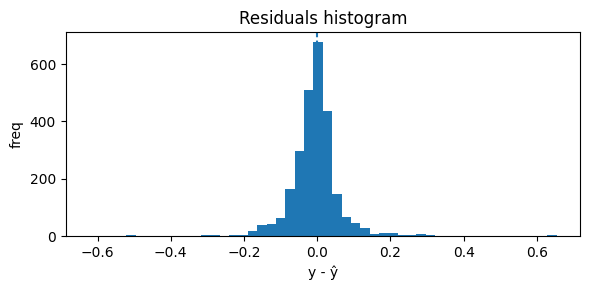

In [ ]:
plt.figure(figsize=(6,3))
plt.hist(te_eval["resid"], bins=50)
plt.axvline(0, linestyle="--")
plt.title("Residuals histogram")
plt.xlabel("y - ŷ")
plt.ylabel("freq")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "lgbm_residuals_histogram_best.png")
)
plt.show()

/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_54218/2081249674.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



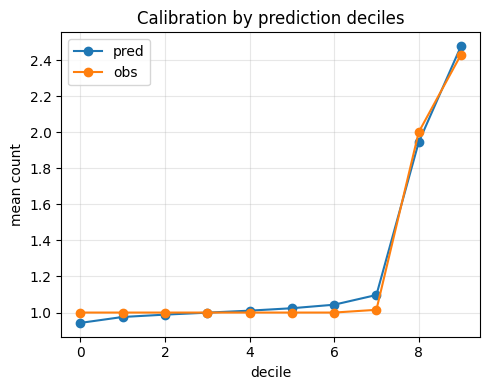

In [ ]:
q = pd.qcut(te_eval["yhat"], 10, duplicates="drop")
cal = te_eval.groupby(q).agg(pred=("yhat","mean"), obs=("y_count","mean")).reset_index(drop=True)
plt.figure(figsize=(5,4))
plt.plot(cal.index, cal["pred"], marker="o", label="pred")
plt.plot(cal.index, cal["obs"],  marker="o", label="obs")
plt.title("Calibration by prediction deciles")
plt.xlabel("decile")
plt.ylabel("mean count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "lgbm_calibration_by_prediction_best.png")
)
plt.show()

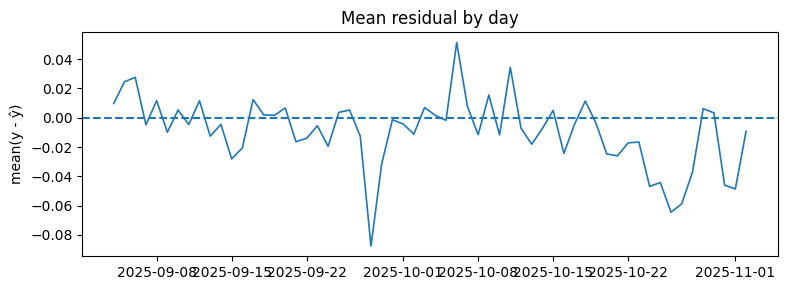

In [ ]:
daily = te_eval.groupby("date")["resid"].mean()
plt.figure(figsize=(8,3))
plt.plot(daily.index, daily.values, linewidth=1.2)
plt.axhline(0, linestyle="--")
plt.title("Mean residual by day")
plt.ylabel("mean(y - ŷ)")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "lgbm_mean_residual_by_day_best.png")
)
plt.show()

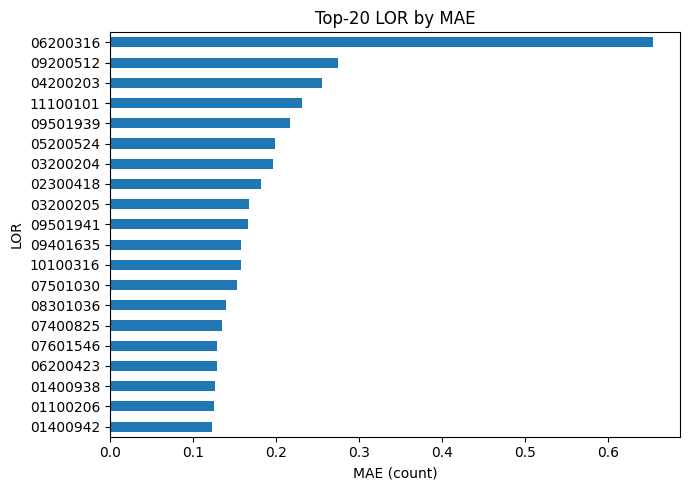

In [ ]:
per_lor = (te_eval.groupby("lor")["resid"].apply(lambda s: s.abs().mean())
                    .sort_values(ascending=False).head(20))
plt.figure(figsize=(7,5))
per_lor.sort_values().plot(kind="barh")
plt.title("Top-20 LOR by MAE")
plt.xlabel("MAE (count)")
plt.ylabel("LOR")
plt.tight_layout()
plt.savefig(
    os.path.join(FIGURES, "lgbm_top_20_lor_by_mae_best.png")
)
plt.show()

## Save model

In [25]:
_zero_like_patterns = [
    r"^y_lag\d+$",          # y_lag1, y_lag7, ...
    r"^y_roll\d+$",         # y_roll7 (прошлые 7 дней, без сегодняшнего)
    r"^y_diff\d+$",         # y_diff1
    r"^zero_streak$",       # длина серии нулей
    r"^spatial_lag_.*$",    # spatial_lag_y_roll7
    r"_roll7_prev$",        # attempt_rate_roll7_prev, price_median_clip_roll7_prev, share_bt_*_roll7_prev
    r"_roll28_prev$",       # если когда-то вернёшь 28-дневные версии
    r"^rate_prev_mean(_1k)?$",  # базовая частота из прошлого (на 1k жителей)
]

def make_zero_like_cols(columns):
    return [c for c in columns if any(re.search(p, c) for p in _zero_like_patterns)]

zero_like_cols = make_zero_like_cols(X_tr.columns)

In [26]:
zero_like_cols

['y_lag1',
 'y_lag7',
 'y_roll7',
 'y_diff1',
 'zero_streak',
 'rate_prev_mean_1k',
 'spatial_lag_y_roll7',
 'attempt_rate_roll7_prev',
 'price_median_clip_roll7_prev',
 'share_bt_diamond_frame_roll7_prev',
 'share_bt_step_through_roll7_prev',
 'share_bt_generic_roll7_prev',
 'share_bt_kids_roll7_prev',
 'share_bt_mtb_roll7_prev',
 'share_bt_other_roll7_prev']

In [27]:
gbm_final.save_model(os.path.join(PROCESSED_DATA, 'bike_thefts_lgbm.pkl'), num_iteration=gbm_final.best_iteration)

In [28]:
X_trval[zero_like_cols] = X_trval[zero_like_cols].fillna(0.0)
imp = X_trval.median(numeric_only=True)
X_trval = X_trval.fillna(imp)

artifacts = {
    "feature_columns": list(X_trval.columns),
    "median_imputer": imp.to_dict(),
    "zero_like_cols": zero_like_cols,
    "best_iteration": gbm_final.best_iteration,
}
with open(os.path.join(PROCESSED_DATA, "preproc.json"), "w") as f:
    json.dump(artifacts, f, ensure_ascii=False, indent=2)